In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов.

In [ ]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [ ]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [ ]:
df.isnull().sum()

Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [ ]:
for col in df.columns:
    if df[col].dtype != 'object':
        df[col].fillna(df[col].mean(), inplace=True)

In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)

In [ ]:
df.describe(include="object")

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
count,131662,131662,131662,131662
unique,5,3,14,2
top,B,B,A,Male
freq,51346,60548,77597,93900


In [ ]:
for col in df.columns:
    if df[col].dtype == "object":
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = df.drop(columns=[col])
        df = pd.concat((df, one_hot), axis=1)

<Axes: >

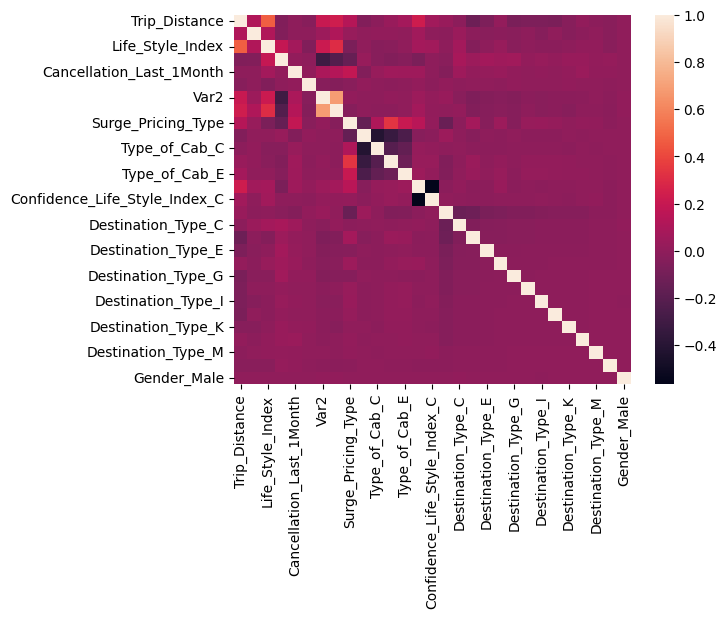

In [ ]:
corr_matrix = df.corr(numeric_only=True)

sns.heatmap(corr_matrix)

In [ ]:
corelations_list = []
for x in corr_matrix:
    for y in corr_matrix:
        if x != y:
            corelations_list.append(corr_matrix[x][y])

corelations_list.sort(reverse=True)
print(round(corelations_list[0], 3))

0.683


### Training

In [ ]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop(columns=["Surge_Pricing_Type"])
y = df["Surge_Pricing_Type"]

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                                     test_size=0.2,
                                                     shuffle=True,
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("one_vs_all", OneVsRestClassifier(LogisticRegression()))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pipe.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.722     0.542     0.619      5372
           2      0.636     0.835     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации!

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [ ]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [ ]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipe, param_grid)

search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_all',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             param_grid={'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1],
                         'one_vs_all__estimator__penalty': ['l1', 'l2',
                                                            'elasticnet']})

In [ ]:
print(search.best_score_)

0.6807621980123324


In [ ]:
pipe.set_params(**search.best_params_)
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

In [ ]:
print(classification_report(y_test, search.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.741     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.575     0.648      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор?

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

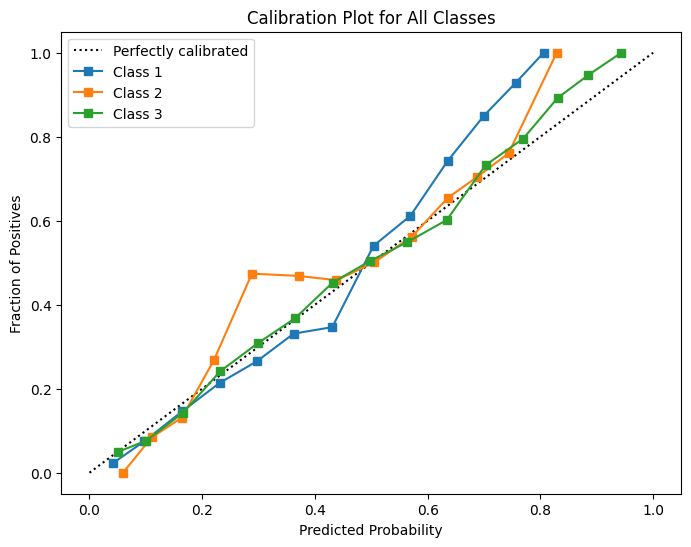

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay, calibration_curve

def Calibrator(X_test, y_test, estimator):
    y_pred = estimator.predict_proba(X_test)
    y_true = pd.get_dummies(y_test)

    # Создаем фигуру и оси для графиков
    fig, ax = plt.subplots(figsize=(8, 6))

    # Создаем калибровочные графики для каждого класса
    for klass in range(3):
        y_klass = np.array([])
        for i in range((y_pred.shape[0])):
            y_klass = np.append(y_klass, y_pred[i][klass])
        # Используем ax=ax для добавления графиков на общие оси
        CalibrationDisplay.from_predictions(y_true[klass+1], y_klass, n_bins=15, ax=ax, name=f'Class {klass+1}')

    # Добавляем легенду, заголовок и подписи осей
    ax.legend()
    ax.set_title('Calibration Plot for All Classes')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Fraction of Positives')

    # Отображаем график
    plt.show()

# Вызываем функцию с моделью
Calibrator(X_test, y_test, search)


**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых.

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [ ]:
### Создание полиномиальных признаков

X_polinomial = X.copy()

In [ ]:
nonbin = X.nunique()>2
nonbin = nonbin[nonbin==True].index.to_list()

# Проходим по всем числовым столбцам
for col in nonbin:
    # Возводим числовые столбцы в степени 2, 3 и 4
    for power in [2, 3, 4]:

        # Вычисляем столбец с возведенными в степень значениями и переименовываем его
        to_add = (X_polinomial[col]**power).to_frame().rename({col:f"{col}_{power}"}, axis=1)

        # Добавляем новый столбец к X_polinomial, объединяя по горизонтали
        X_polinomial = pd.concat((X_polinomial, to_add), axis=1)


In [ ]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y,
                                                             test_size=0.2,
                                                             shuffle=True,
                                                             random_state=2022)

In [ ]:
pipe.fit(X_pol_train, y_train)

print(classification_report(y_test, pipe.predict(X_pol_test), digits=3))

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.740     0.585     0.653      9612

    accuracy                          0.682     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.682     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

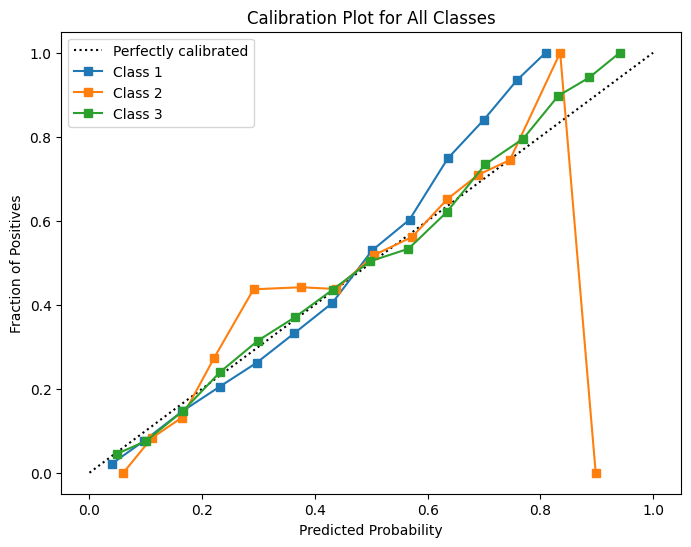

In [ ]:
pipe_poly = pipe
pipe_poly.fit(X_pol_train, y_train)

Calibrator(X_pol_test, y_test, pipe_poly)

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                                     test_size=0.2,
                                                     shuffle=True,
                                                     random_state=2022)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

scaler = StandardScaler()
X_train_trans = scaler.fit_transform(X_train)
X_test_trans = scaler.transform(X_test)

In [ ]:
classifier = SGDClassifier(random_state=42)
OvO = OneVsOneClassifier(classifier)
OvO.fit(X_train_trans, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [ ]:
print(classification_report(y_test, OvO.predict(X_test_trans), digits=3))

              precision    recall  f1-score   support

           1      0.738     0.528     0.615      5372
           2      0.625     0.864     0.725     11349
           3      0.754     0.533     0.624      9612

    accuracy                          0.675     26333
   macro avg      0.706     0.642     0.655     26333
weighted avg      0.695     0.675     0.666     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [ ]:
param_grid = {'estimator__loss': ['hinge', 'log', 'modified_huber'],
              'estimator__penalty': ['l1', 'l2'],
              'estimator__alpha': [0.001, 0.01, 0.1]}

In [ ]:
search = GridSearchCV(OvO, param_grid, n_jobs=-1)

search.fit(X_train_trans, y_train)

print(classification_report(y_test, search.predict(X_test_trans), digits=3))

              precision    recall  f1-score   support

           1      0.743     0.528     0.617      5372
           2      0.625     0.876     0.730     11349
           3      0.767     0.527     0.624      9612

    accuracy                          0.678     26333
   macro avg      0.712     0.644     0.657     26333
weighted avg      0.701     0.678     0.668     26333



In [ ]:
print(search.best_params_)

{'estimator__alpha': 0.001, 'estimator__loss': 'hinge', 'estimator__penalty': 'l1'}


Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?

-- Кажется, что у каждого подхода есть свои плюсы и минусы. Хотя в МО обычно опираются на качество работы алгоритмов, и если оно существенное, то можно однозначно сказать, какой из них лучше